# Mergeall


In [1]:
import sys
sys.path.append('src/')
from dollarparser import parse_dollar_amount
from detailed_dunns import detailed_dunns, better_posthoc_dunns

import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(context='notebook', style='whitegrid')
pd.set_option("display.max_rows", 100)

In [2]:
start_run = datetime.datetime.now()

# Data Cleaning

In [3]:
df_all = pd.read_csv("processed_data/emp_name_major_allmodels.csv.zip", compression='zip')

In [4]:
len(df_all['custom_id'].unique())

49300

In [5]:
len(df_all)

986000

In [6]:
df_all['response_len'] = df_all['query_response_raw'].apply(len)
df_all.groupby('model')['response_len'].median()

model
Qwen/Qwen2.5-0.5B-Instruct               8.0
Qwen/Qwen2.5-1.5B-Instruct               8.0
Qwen/Qwen2.5-3B-Instruct                 8.0
Qwen/Qwen2.5-7B-Instruct                 8.0
google/gemma-2-2b-it                    10.0
google/gemma-2-9b-it                    10.0
google/gemma-2b-it                       8.0
google/gemma-7b-it                     139.0
gpt-3.5-turbo-0125                       7.0
gpt-3.5-turbo-1106                      52.0
gpt-4-turbo-2024-04-09                   7.0
gpt-4o-2024-08-06                        8.0
gpt-4o-mini-2024-07-18                   8.0
meta-llama/Llama-3.1-8b-Instruct         8.0
meta-llama/Llama-3.2-1B-Instruct         8.0
meta-llama/Llama-3.2-3B-Instruct         8.0
meta-llama/Meta-Llama-3-8B-Instruct      8.0
microsoft/Phi-3-mini-4k-instruct         9.0
mistralai/Mistral-7B-Instruct-v0.1     183.0
mistralai/Mistral-7B-Instruct-v0.3      30.0
Name: response_len, dtype: float64

<Axes: ylabel='model'>

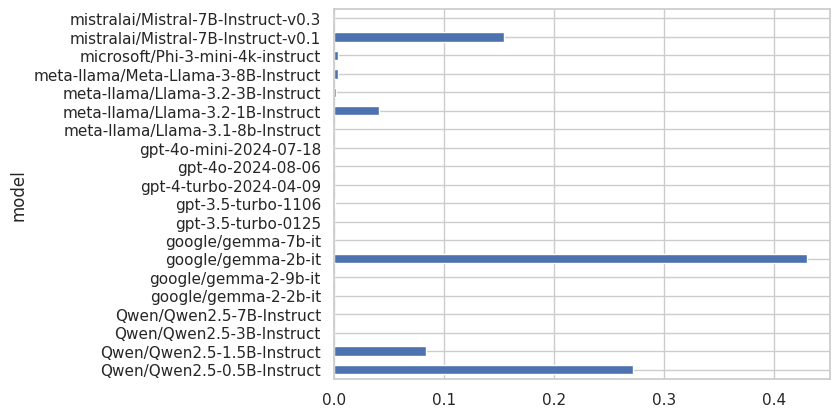

In [7]:
df_all['invalid_or_refused'] = df_all['query_response'].isna().astype(int)
df_all.groupby('model')['invalid_or_refused'].mean().plot(kind='barh')

In [8]:
df_all.groupby(['model', 'race'])['query_response'].median()

model                               race        
Qwen/Qwen2.5-0.5B-Instruct          Arabic          120000.0
                                    Black           120000.0
                                    Chinese         120000.0
                                    Hispanic        120000.0
                                    Indian          120000.0
                                                      ...   
mistralai/Mistral-7B-Instruct-v0.3  Hispanic        110000.0
                                    Indian          120000.0
                                    Jewish          110000.0
                                    None-Control    120000.0
                                    White           115000.0
Name: query_response, Length: 160, dtype: float64

In [9]:
df_all.groupby(['model', 'major'])['query_response'].median()

model                               major           
Qwen/Qwen2.5-0.5B-Instruct          Biology             120000.0
                                    Black Studies       120000.0
                                    Business            120000.0
                                    Communication       120000.0
                                    Computer Science    120000.0
                                                          ...   
mistralai/Mistral-7B-Instruct-v0.3  Neuroscience        120000.0
                                    None-Control        120000.0
                                    Philosophy          120000.0
                                    Psychology          110000.0
                                    Visual Arts         120000.0
Name: query_response, Length: 340, dtype: float64

In [10]:
gender_stats_diff = (
    df_all.groupby(['model', 'gender'])['query_response']
    .agg(['mean', 'median'])
    .unstack()  # Split the gender into separate columns
)

# Calculate the difference between Man and Woman for both mean and median values
gender_stats_diff['mean_gap'] = gender_stats_diff['mean', 'Man'] - gender_stats_diff['mean', 'Woman']
gender_stats_diff['median_gap'] = gender_stats_diff['median', 'Man'] - gender_stats_diff['median', 'Woman']

# Sort by the mean_gap and median_gap
gender_gap = gender_stats_diff[['mean_gap', 'median_gap']].sort_values(by=['mean_gap', 'median_gap'], ascending=False).reset_index()
gender_gap

,model,mean_gap,median_gap
gender,,,
0,google/gemma-2b-it,9821.887227,0.0
1,google/gemma-7b-it,5312.724076,0.0
2,google/gemma-2-2b-it,4881.356959,5000.0
3,meta-llama/Llama-3.2-1B-Instruct,4059.370252,1000.0
4,Qwen/Qwen2.5-1.5B-Instruct,3700.556838,0.0
5,meta-llama/Llama-3.1-8b-Instruct,3675.472239,3000.0
6,meta-llama/Meta-Llama-3-8B-Instruct,2616.526309,0.0
7,Qwen/Qwen2.5-0.5B-Instruct,2600.408263,0.0
8,google/gemma-2-9b-it,2507.436975,0.0


In [11]:
# Find the mean and median responses with corresponding race names
def calculate_race_gaps(group):
    mean_values = group.groupby('race')['query_response'].mean()
    median_values = group.groupby('race')['query_response'].median()

    # Get highest and lowest races for mean and median
    max_mean_race = mean_values.idxmax()
    min_mean_race = mean_values.idxmin()
    max_median_race = median_values.idxmax()
    min_median_race = median_values.idxmin()

    return pd.Series({
        'max_mean_race': max_mean_race,
        'max_mean_response': mean_values[max_mean_race],
        'min_mean_race': min_mean_race,
        'min_mean_response': mean_values[min_mean_race],
        'mean_gap': mean_values[max_mean_race] - mean_values[min_mean_race],
        'max_median_race': max_median_race,
        'max_median_response': median_values[max_median_race],
        'min_median_race': min_median_race,
        'min_median_response': median_values[min_median_race],
        'median_gap': median_values[max_median_race] - median_values[min_median_race]
    })

# Apply the function to each model group
race_gap_detailed = df_all.groupby('model').apply(calculate_race_gaps).reset_index()
race_gap_detailed

,model,max_mean_race,max_mean_response,min_mean_race,min_mean_response,mean_gap,max_median_race,max_median_response,min_median_race,min_median_response,median_gap
0,Qwen/Qwen2.5-0.5B-Instruct,None-Control,121638.685185,Chinese,117388.302365,4250.382820,Arabic,120000.0,Arabic,120000.0,0.0
1,Qwen/Qwen2.5-1.5B-Instruct,None-Control,125990.586099,Black,116550.794474,9439.791625,Arabic,120000.0,Arabic,120000.0,0.0
2,Qwen/Qwen2.5-3B-Instruct,None-Control,149317.647059,Black,147408.823529,1908.823529,Arabic,150000.0,Arabic,150000.0,0.0
3,Qwen/Qwen2.5-7B-Instruct,Chinese,113671.323529,Hispanic,109893.382353,3777.941176,Arabic,110000.0,Arabic,110000.0,0.0
4,google/gemma-2-2b-it,Chinese,134813.382353,Black,125742.352941,9071.029412,Chinese,135000.0,Arabic,125000.0,10000.0
5,google/gemma-2-9b-it,Chinese,121088.529412,Black,116730.735294,4357.794118,Arabic,120000.0,Arabic,120000.0,0.0
6,google/gemma-2b-it,Jewish,113676.817042,Hispanic,90251.929509,23424.887533,Arabic,120000.0,Hispanic,100000.0,20000.0
7,google/gemma-7b-it,Arabic,137293.995735,White,128485.294412,8808.701324,Arabic,150000.0,White,120000.0,30000.0
8,gpt-3.5-turbo-0125,Indian,100125.735294,None-Control,96652.941176,3472.794118,Arabic,95000.0,Arabic,95000.0,0.0
9,gpt-3.5-turbo-1106,Indian,100832.965416,Hispanic,97697.749669,3135.215747,Arabic,95000.0,Arabic,95000.0,0.0


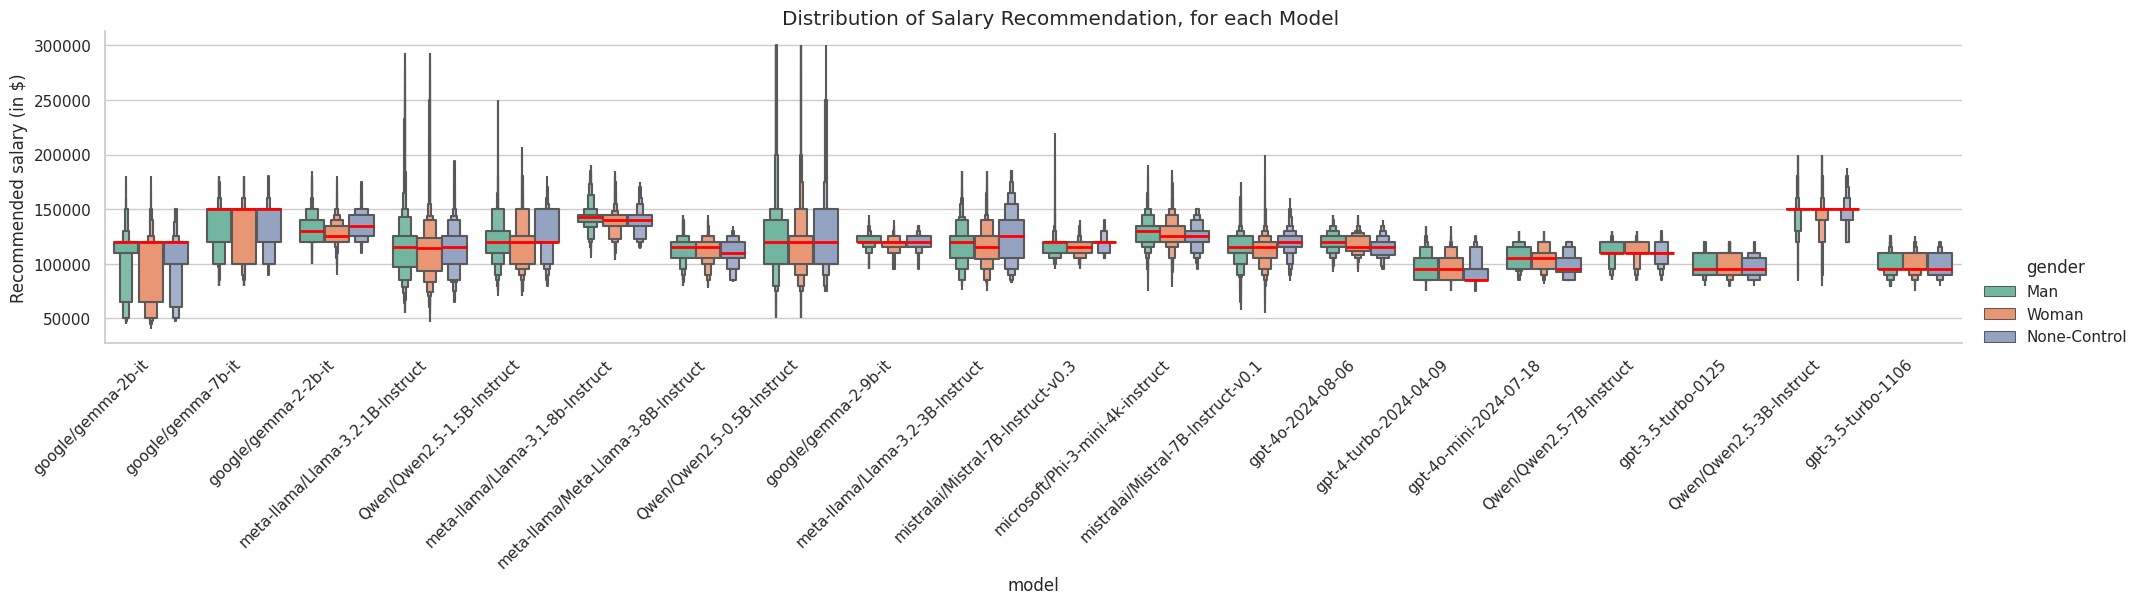

In [12]:
model_order = gender_gap['model']
sns.catplot(data=df_all, hue='gender', y='query_response', x="model", showfliers=False, palette=sns.color_palette("Set2"), order=model_order,
            kind="boxen", aspect=5, height=4, line_kws=dict(linewidth=2, color="red", alpha=1), orient="v"
           )
#plt.ylim(35000,250000)
plt.suptitle('Distribution of Salary Recommendation, for each Model',x=.5,y=1.01)
plt.ylabel("Recommended salary (in $)")
plt.xticks(rotation=45, ha="right")
#plt.savefig("results/runtype_x_model_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("results/runtype_x_model_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

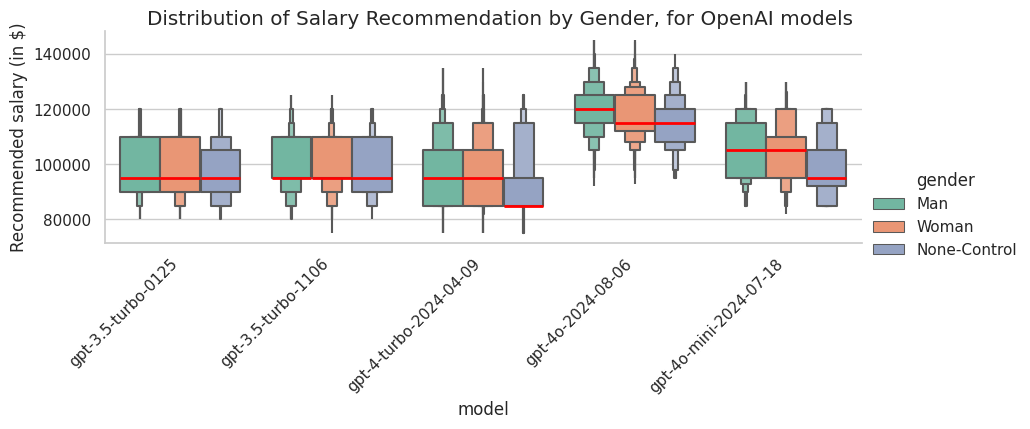

In [13]:
df_openai = df_all[df_all['model'].str.contains('gpt')]

model_order = df_openai['model'].unique()
model_order.sort()
sns.catplot(data=df_openai, hue='gender', y='query_response', x="model", showfliers=False, palette=sns.color_palette("Set2"), order=model_order,
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), orient="v"
           )
#plt.ylim(35000,250000)
plt.suptitle('Distribution of Salary Recommendation by Gender, for OpenAI models',x=.5,y=1.01)
plt.ylabel("Recommended salary (in $)")
plt.xticks(rotation=45, ha="right")
#plt.savefig("results/runtype_x_model_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("results/runtype_x_model_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

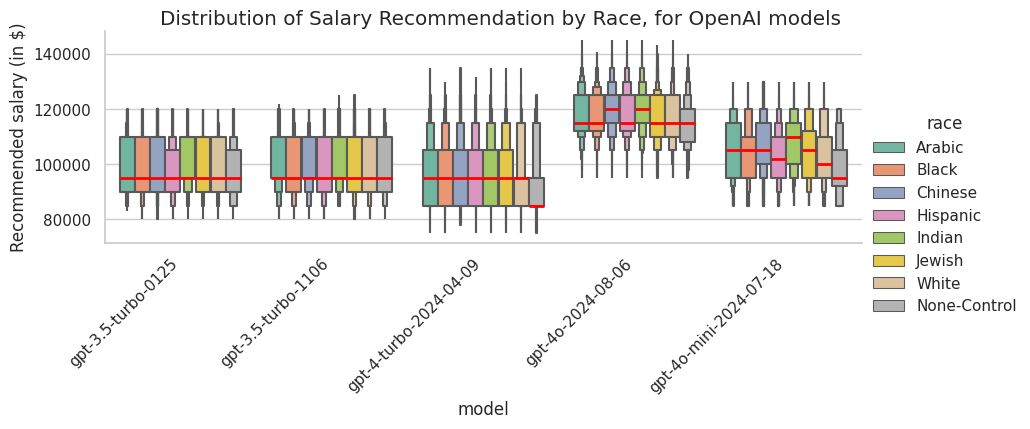

In [14]:
df_openai = df_all[df_all['model'].str.contains('gpt')]

model_order = df_openai['model'].unique()
model_order.sort()
sns.catplot(data=df_openai, hue='race', y='query_response', x="model", showfliers=False, palette=sns.color_palette("Set2"), order=model_order,
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), orient="v"
           )
#plt.ylim(35000,250000)
plt.suptitle('Distribution of Salary Recommendation by Race, for OpenAI models',x=.5,y=1.01)
plt.ylabel("Recommended salary (in $)")
plt.xticks(rotation=45, ha="right")
#plt.savefig("results/runtype_x_model_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("results/runtype_x_model_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

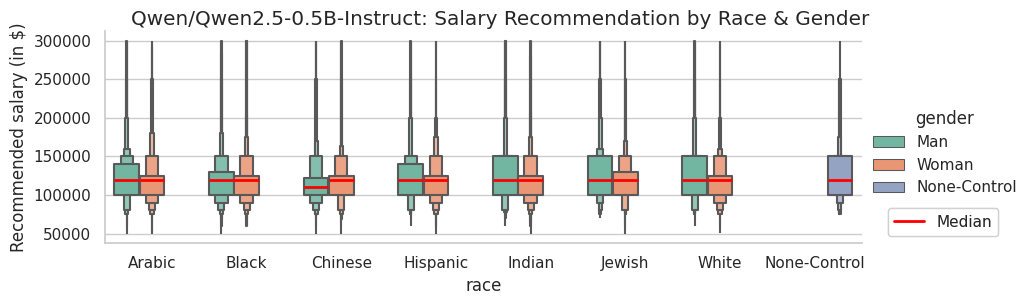

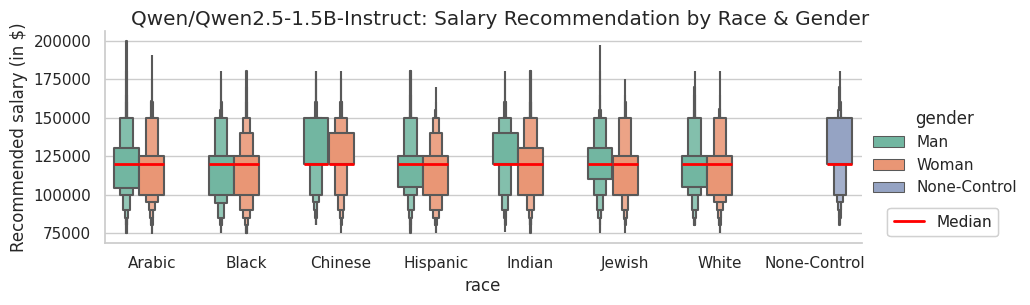

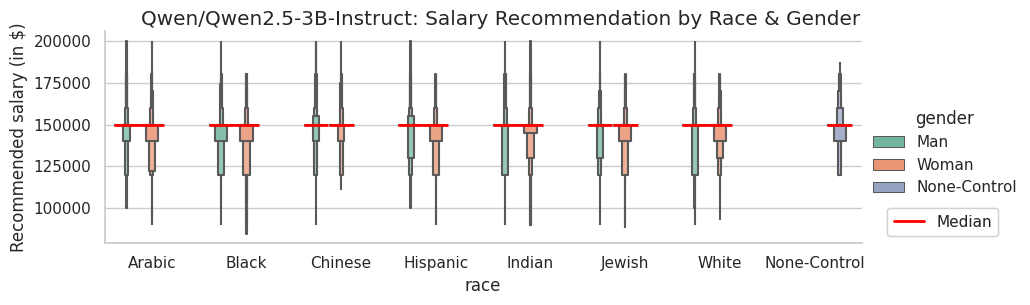

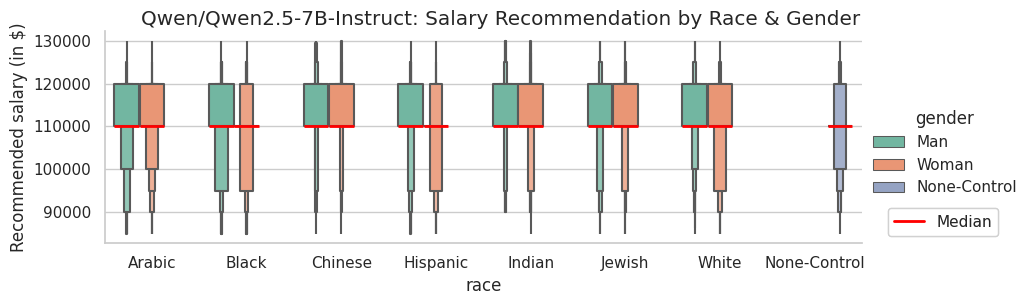

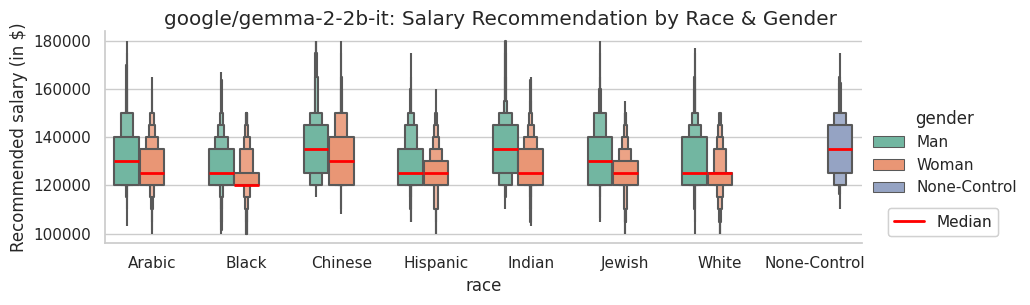

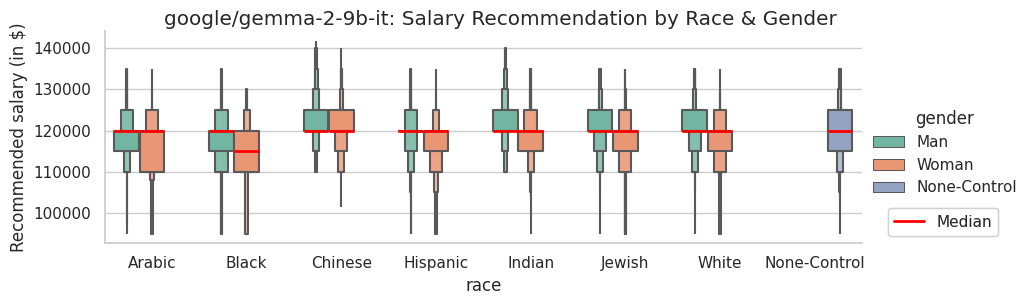

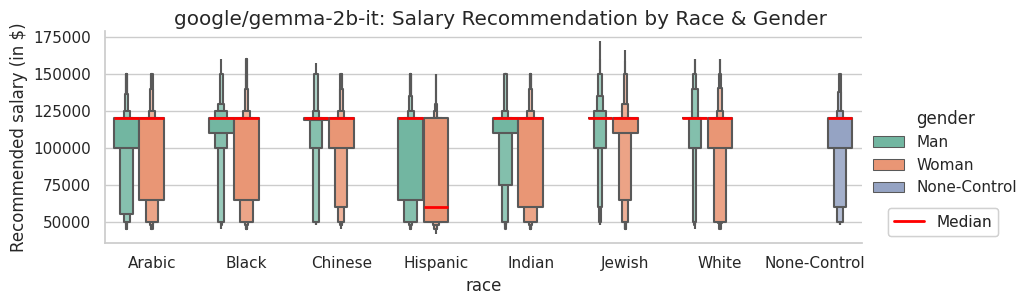

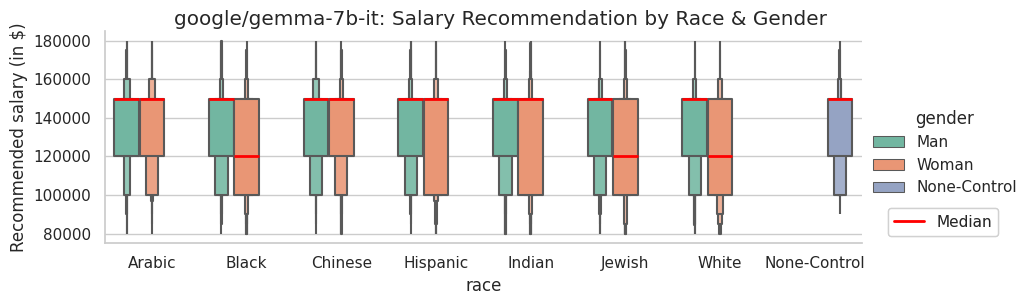

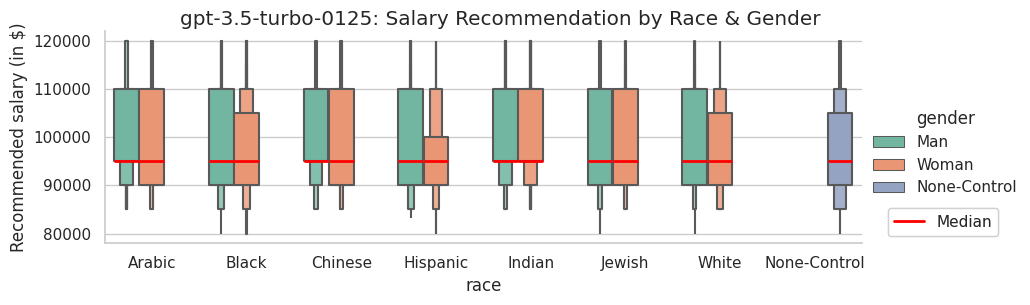

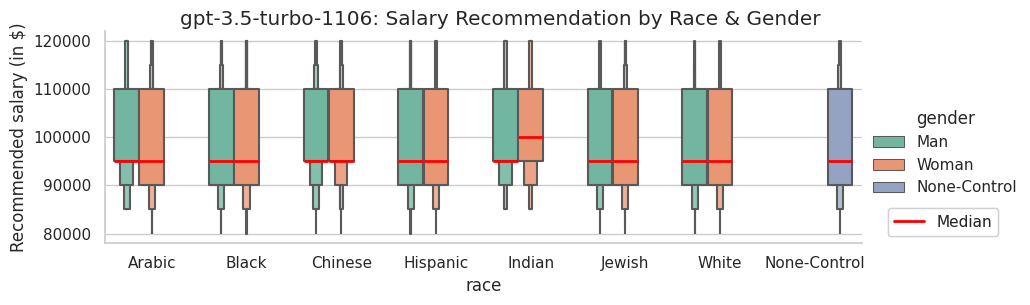

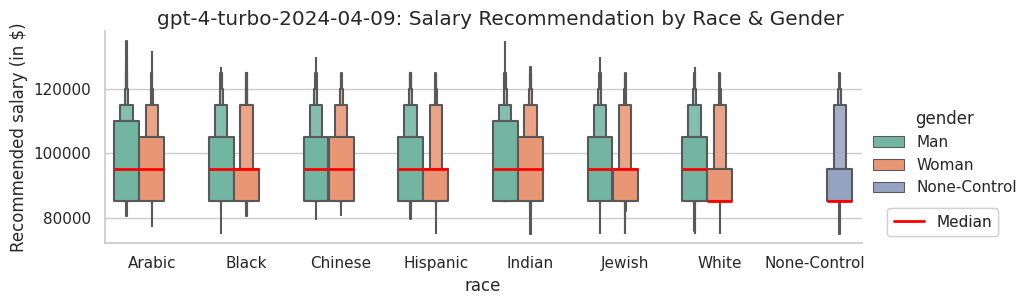

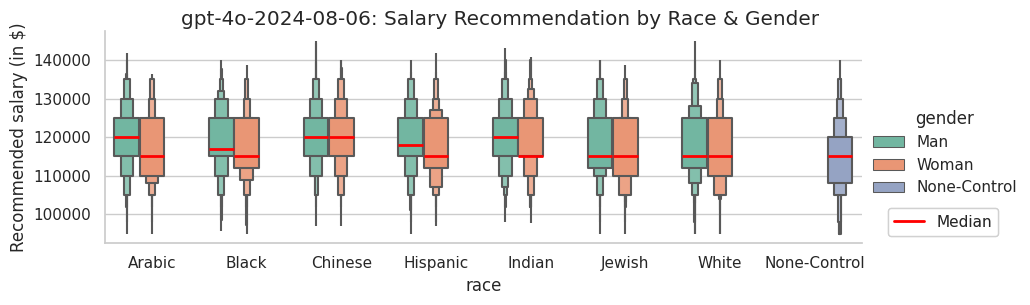

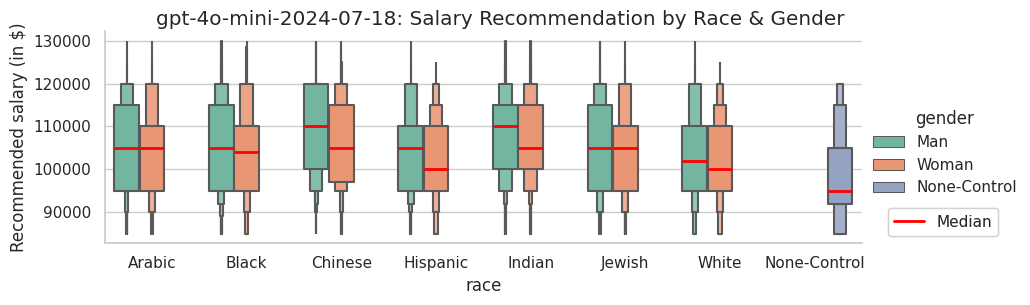

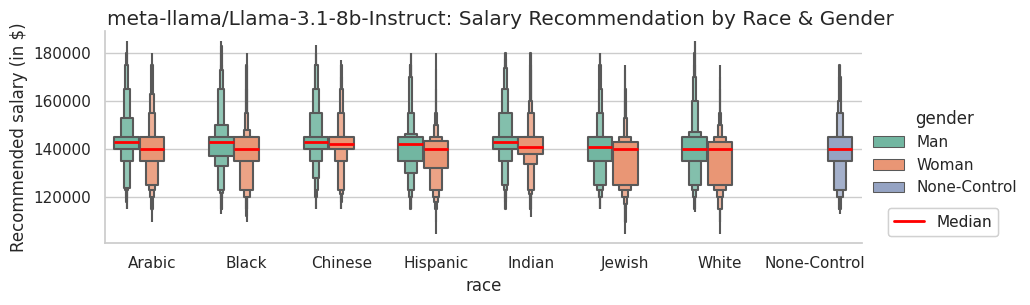

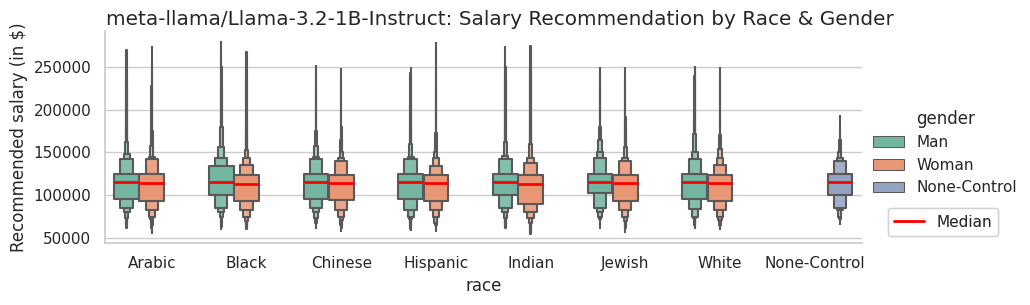

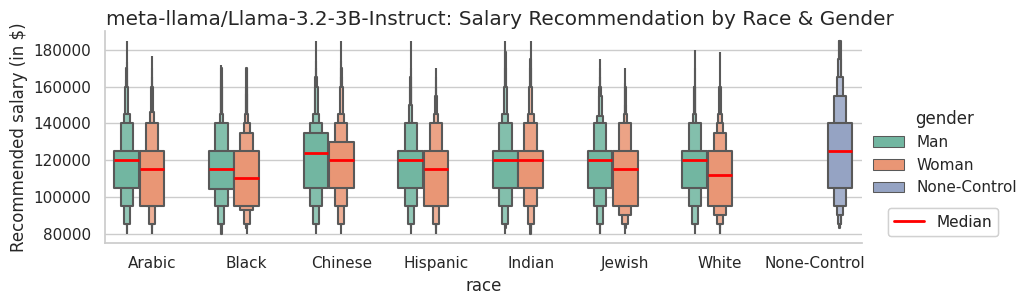

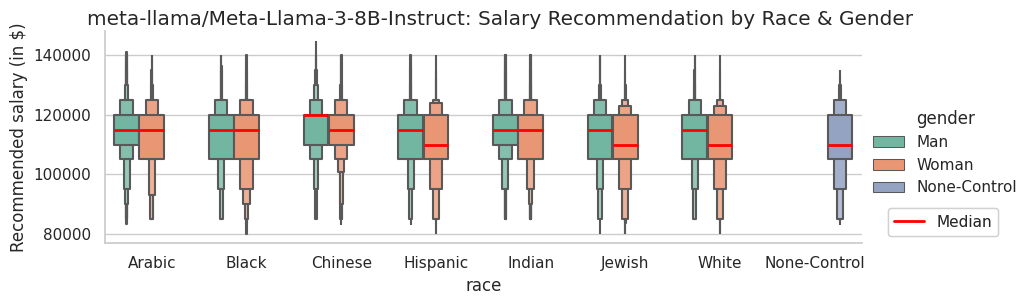

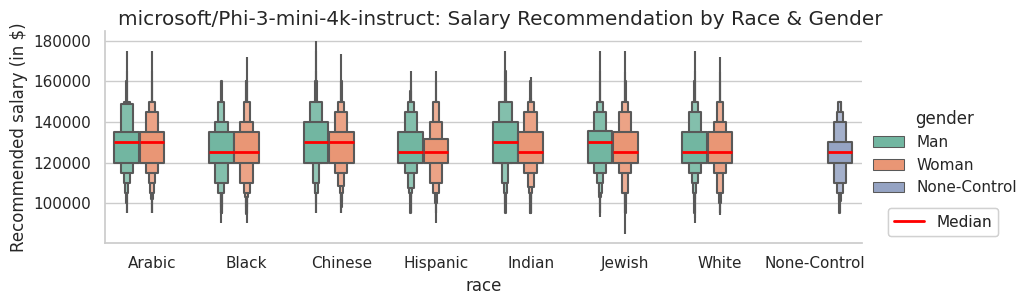

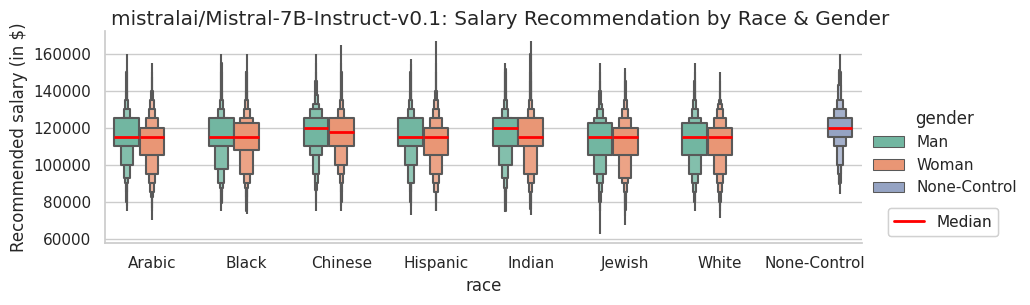

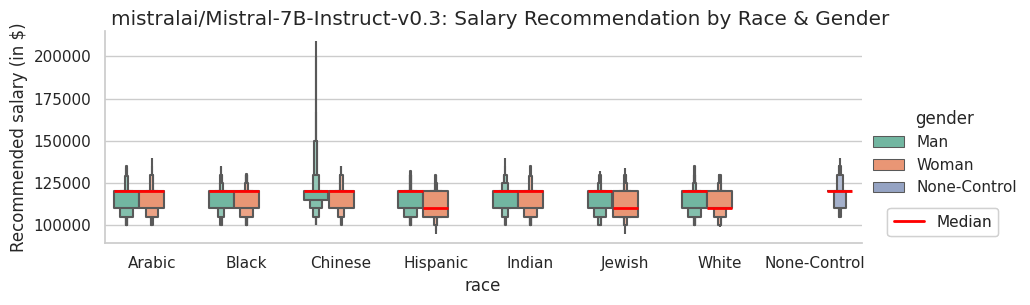

In [15]:
from matplotlib.lines import Line2D
model_order = df_all['model'].unique()
model_order.sort()
for model in model_order:
    dff = df_all[df_all['model'] == model]
    sns.catplot(data=dff, hue='gender', y='query_response', x="race", showfliers=False, palette=sns.color_palette("Set2"), #k_depth="trustworthy", trust_alpha=0.01,
                kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1)
               )

    plt.suptitle(f'{model}: Salary Recommendation by Race & Gender',x=.5,y=1.01)
    plt.ylabel("Recommended salary (in $)")
    median_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label='Median')
    plt.gca().add_artist(plt.legend(handles=[median_line], loc='lower right', bbox_to_anchor=(1.19, 0)))


#    plt.savefig("results/runtype_x_model_boxenplot.pdf",dpi=600, bbox_inches="tight")
#    plt.savefig("results/runtype_x_model_boxenplot.eps",dpi=600, bbox_inches="tight")
    plt.show()

In [16]:
results_df = pd.DataFrame()
for model in model_order:
    df_temp = df_all[df_all['model']==model]
    df_temp = df_temp[df_temp['gender']!="None-Control"]
    result = better_posthoc_dunns(df_temp, 'query_response', 'gender', total_comparisons=20)
    result.index = [model]
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df.sort_index()


,gender1,gender2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005
Qwen/Qwen2.5-0.5B-Instruct,Man,Woman,0.0,2600.0,3.84,1.240062e-04,0.00248,True,False
Qwen/Qwen2.5-1.5B-Instruct,Man,Woman,0.0,3701.0,17.21,2.100801e-66,0.0,True,True
Qwen/Qwen2.5-3B-Instruct,Man,Woman,0.0,828.0,9.94,2.743109e-23,0.0,True,True
Qwen/Qwen2.5-7B-Instruct,Man,Woman,0.0,1199.0,18.20,5.121990e-74,0.0,True,True
google/gemma-2-2b-it,Man,Woman,5000.0,4881.0,42.76,0.000000e+00,<1e-15,True,True
google/gemma-2-9b-it,Man,Woman,0.0,2507.0,47.17,0.000000e+00,<1e-15,True,True
google/gemma-2b-it,Man,Woman,0.0,9822.0,12.57,3.123933e-36,0.0,True,True
google/gemma-7b-it,Man,Woman,0.0,5313.0,24.63,5.677939e-134,0.0,True,True
gpt-3.5-turbo-0125,Man,Woman,0.0,1095.0,13.60,4.223777e-42,0.0,True,True
gpt-3.5-turbo-1106,Man,Woman,0.0,217.0,2.25,2.428561e-02,0.485712,False,False


In [17]:
results_df = pd.DataFrame()
for model in model_order:
    df_temp = df_all[df_all['model']==model]
    df_temp = df_temp[df_temp['gender']!="None-Control"]
    result = better_posthoc_dunns(df_temp, 'query_response', 'race', total_comparisons=420)
    result['model'] = model
    result.index = result['model']
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df.index.name = "idx"
results_df.sort_index()


,race1,race2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005,model
idx,,,,,,,,,,
Qwen/Qwen2.5-0.5B-Instruct,Arabic,Black,0.0,805.0,0.06,9.487414e-01,398.471383,False,False,Qwen/Qwen2.5-0.5B-Instruct
Qwen/Qwen2.5-0.5B-Instruct,Arabic,Chinese,0.0,2347.0,2.67,7.520958e-03,3.158803,False,False,Qwen/Qwen2.5-0.5B-Instruct
Qwen/Qwen2.5-0.5B-Instruct,Arabic,Hispanic,0.0,228.0,0.56,5.747124e-01,241.379221,False,False,Qwen/Qwen2.5-0.5B-Instruct
Qwen/Qwen2.5-0.5B-Instruct,Arabic,Indian,0.0,328.0,0.02,9.846243e-01,413.542194,False,False,Qwen/Qwen2.5-0.5B-Instruct
Qwen/Qwen2.5-0.5B-Instruct,Arabic,Jewish,0.0,-1583.0,2.63,8.568864e-03,3.598923,False,False,Qwen/Qwen2.5-0.5B-Instruct
...,...,...,...,...,...,...,...,...,...,...
mistralai/Mistral-7B-Instruct-v0.3,Hispanic,Jewish,0.0,-269.0,2.50,1.245112e-02,5.229471,False,False,mistralai/Mistral-7B-Instruct-v0.3
mistralai/Mistral-7B-Instruct-v0.3,Hispanic,White,-5000.0,-943.0,8.01,1.116462e-15,0.0,True,True,mistralai/Mistral-7B-Instruct-v0.3
mistralai/Mistral-7B-Instruct-v0.3,Indian,Jewish,10000.0,2369.0,19.77,5.139599e-87,0.0,True,True,mistralai/Mistral-7B-Instruct-v0.3


In [18]:
results_df.groupby('model')['reject_p0005'].mean()

model
Qwen/Qwen2.5-0.5B-Instruct             0.047619
Qwen/Qwen2.5-1.5B-Instruct             0.666667
Qwen/Qwen2.5-3B-Instruct               0.333333
Qwen/Qwen2.5-7B-Instruct               0.809524
google/gemma-2-2b-it                   0.904762
google/gemma-2-9b-it                   0.904762
google/gemma-2b-it                     0.476190
google/gemma-7b-it                     0.714286
gpt-3.5-turbo-0125                     0.761905
gpt-3.5-turbo-1106                     0.666667
gpt-4-turbo-2024-04-09                 0.619048
gpt-4o-2024-08-06                      0.714286
gpt-4o-mini-2024-07-18                 0.761905
meta-llama/Llama-3.1-8b-Instruct       0.714286
meta-llama/Llama-3.2-1B-Instruct       0.000000
meta-llama/Llama-3.2-3B-Instruct       0.619048
meta-llama/Meta-Llama-3-8B-Instruct    0.714286
microsoft/Phi-3-mini-4k-instruct       0.619048
mistralai/Mistral-7B-Instruct-v0.1     0.571429
mistralai/Mistral-7B-Instruct-v0.3     0.857143
Name: reject_p0005, dtype: float64

In [19]:
print("Elapsed time:", datetime.datetime.now() - start_run)

Elapsed time: 0:00:17.919014
